# Explainable AI - Airline Passenger Satisfaction

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scikit-learn==1.6.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# !pip install lightgbm==4.6.0
import lightgbm as lgb

# !pip install optuna==4.3.0
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate

# !pip install shap==0.47.2
import shap

pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings("ignore")

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # !pip install -U -q "google-genai>=0.3.0"
# import os
# import time
# import json
# from tqdm import tqdm
# from pprint import pprint

# from google import genai
# # from google.genai import types

In [3]:
color_1 = 'mediumpurple'
color_2 = 'olivedrab'

cmap='mako_r'

### Helper Functions

In [4]:
# Function to get the top N column names for a given row
def get_top_bottom_n_columns(row, n=5):
    # Most positive
    top_col_list = row.nlargest(n).index.tolist()
    top_col_list = [c.replace("_SHAP", "") for c in top_col_list]
    # Most negative
    bottom_col_list = row.nsmallest(n).index.tolist()
    bottom_col_list = [c.replace("_SHAP", "") for c in bottom_col_list]

    return top_col_list, bottom_col_list

### Load Data

In [5]:
train_df = pd.read_csv('train.csv', low_memory=False)
train_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
train_df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,satisfied
103901,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [6]:
test_df = pd.read_csv('test.csv', low_memory=False)
test_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
test_df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
25973,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied


### Pre-Processing

In [7]:
train_df['satisfaction'].value_counts()

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64

In [8]:
test_df['satisfaction'].value_counts()

satisfaction
neutral or dissatisfied    14573
satisfied                  11403
Name: count, dtype: int64

In [9]:
train_df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [10]:
test_df.isna().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

In [11]:
train_df['Arrival Delay in Minutes'] = train_df['Arrival Delay in Minutes'].fillna(0)
test_df['Arrival Delay in Minutes'] = test_df['Arrival Delay in Minutes'].fillna(0)

In [12]:
# Binary encoding
train_df['satisfaction'] = np.where(train_df['satisfaction'] == 'satisfied', 1, 0)
test_df['satisfaction'] = np.where(test_df['satisfaction'] == 'satisfied', 1, 0)

In [13]:
# Identify object columns
categorical_features = train_df.select_dtypes(include='object').columns.tolist()

# Convert identified columns to 'category'
for col in categorical_features:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [14]:
categorical_features

['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [15]:
train_df['satisfaction'].unique().tolist()

[0, 1]

In [16]:
target = 'satisfaction'
features = [c for c in train_df.columns.tolist() if c != target]

In [17]:
numerical_features = [f for f in features if f not in categorical_features]
numerical_features

['Age',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

### Split Data

In [18]:
# Split train into train and train/val by percentage
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)
# Split into val and test/val by percentage
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [19]:
# Use the origianl test df as a holdout set
X = test_df[features]
y = test_df[target]

In [20]:
print(f'X_train: {len(X_train)}')
print(f'X_val: {len(X_val)}')
print(f'X_test: {len(X_test)}')
print(f'X: {len(X)}')

X_train: 83123
X_val: 10391
X_test: 10390
X: 25976


### Training

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83123 entries, 20921 to 15795
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             83123 non-null  category
 1   Customer Type                      83123 non-null  category
 2   Age                                83123 non-null  int64   
 3   Type of Travel                     83123 non-null  category
 4   Class                              83123 non-null  category
 5   Flight Distance                    83123 non-null  int64   
 6   Inflight wifi service              83123 non-null  int64   
 7   Departure/Arrival time convenient  83123 non-null  int64   
 8   Ease of Online booking             83123 non-null  int64   
 9   Gate location                      83123 non-null  int64   
 10  Food and drink                     83123 non-null  int64   
 11  Online boarding                    83123 n

In [22]:
# Parameters for the current model
current_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',
    'n_estimators':1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'scale_pos_weight': 0.5,
    'n_jobs': -1,
    'verbose': -1,
}

In [23]:
# Initialize the LightGBMClassifier
lgbm_model = lgb.LGBMClassifier(**current_params)

# Train the LightGBM model with early stopping
eval_set = [(X_train, y_train), (X_val, y_val)]
evals_result = {}

lgbm_model.fit(X_train, y_train,
                categorical_feature=categorical_features,
                eval_set=eval_set,
                eval_metric=['auc', 'binary_logloss'],
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=1),
                            lgb.record_evaluation(evals_result)])

# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[366]	training's auc: 0.997674	training's binary_logloss: 0.0704755	valid_1's auc: 0.9955	valid_1's binary_logloss: 0.0862411


In [24]:
# Extract the best number of estimators
best_n_estimators = lgbm_model.best_iteration_
print(f"\nBest number of estimators: {best_n_estimators}")


Best number of estimators: 366


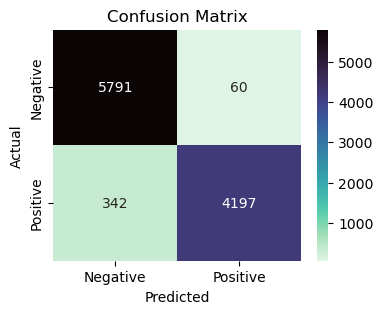

In [25]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Print classification report (F1-score, Recall, Precision)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5851
           1       0.99      0.92      0.95      4539

    accuracy                           0.96     10390
   macro avg       0.97      0.96      0.96     10390
weighted avg       0.96      0.96      0.96     10390



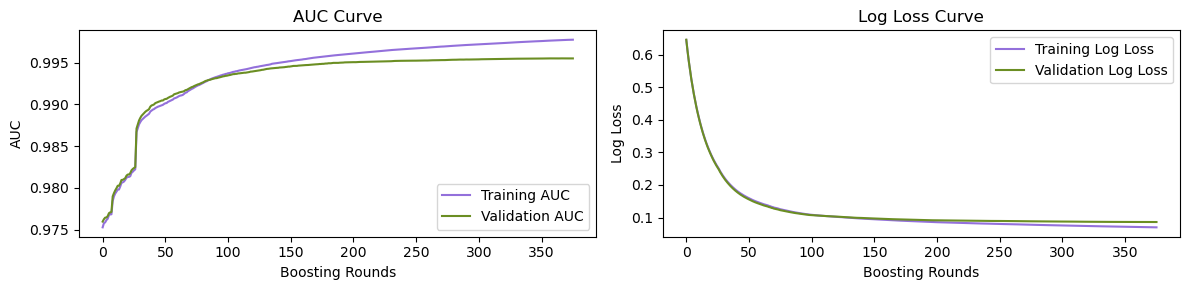

In [27]:
# Visualize the loss curves
epochs = len(evals_result['training']['auc']) 
plt.figure(figsize=(12, 3))

# Plot AUC
plt.subplot(1, 2, 1)
plt.plot(evals_result['training']['auc'], label='Training AUC', color = color_1)
plt.plot(evals_result['valid_1']['auc'], label='Validation AUC', color = color_2)
plt.title('AUC Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()

# Plot Log Loss
plt.subplot(1, 2, 2)
plt.plot(evals_result['training']['binary_logloss'], label='Training Log Loss', color = color_1)
plt.plot(evals_result['valid_1']['binary_logloss'], label='Validation Log Loss', color = color_2)
plt.title('Log Loss Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Retraining

In [28]:
# Parameters for the current model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',
    'n_estimators':best_n_estimators,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'scale_pos_weight': 0.5,
    'n_jobs': -1,
    'verbose': -1,
}

In [29]:
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

print(f'X_test: {len(X_test)}')

X_test: 20781


In [30]:
# Initialize the LightGBMClassifier
lgbm_model = lgb.LGBMClassifier(**current_params)

lgbm_model.fit(X_train, y_train,
                categorical_feature=categorical_features,
                )

# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

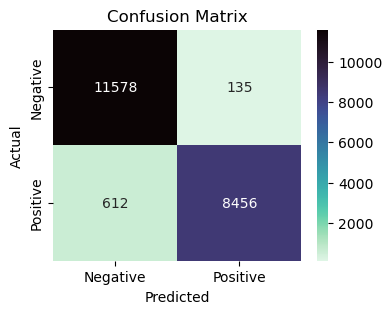

In [31]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Training Calibrate Predicted Probability

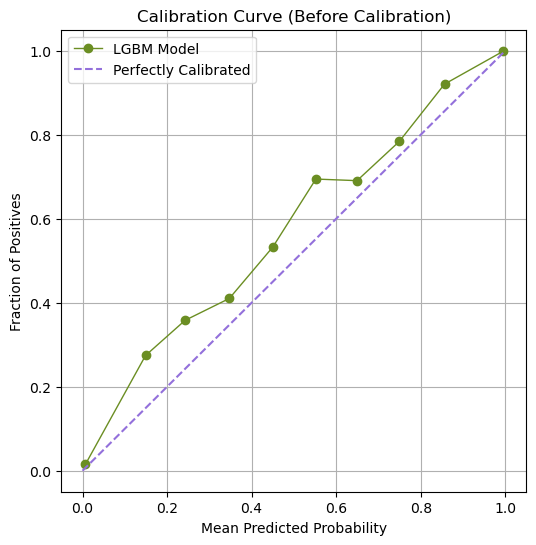

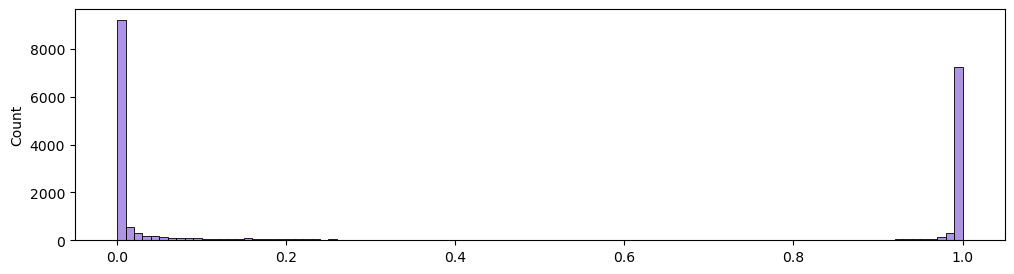

In [32]:
calibrated_pred_proba = lgbm_model.predict_proba(X_test)[:,1]
binned_true_p, binned_predict_p = calibration_curve(y_test, calibrated_pred_proba, n_bins=10)


plt.figure(figsize=(6, 6))
plt.plot(binned_predict_p, binned_true_p, marker='o', linewidth=1, label='LGBM Model', color = color_2)
plt.plot([0, 1], [0, 1], linestyle='--', color=color_1, label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Before Calibration)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


plt.figure(figsize = (12, 3))
sns.histplot(calibrated_pred_proba, bins=100, color=color_1)
plt.show()

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


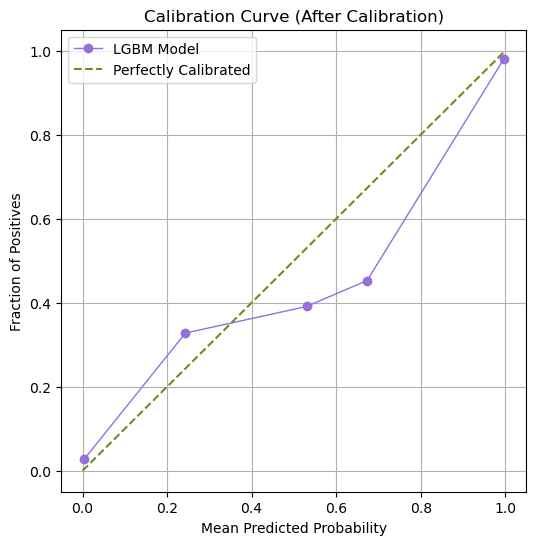

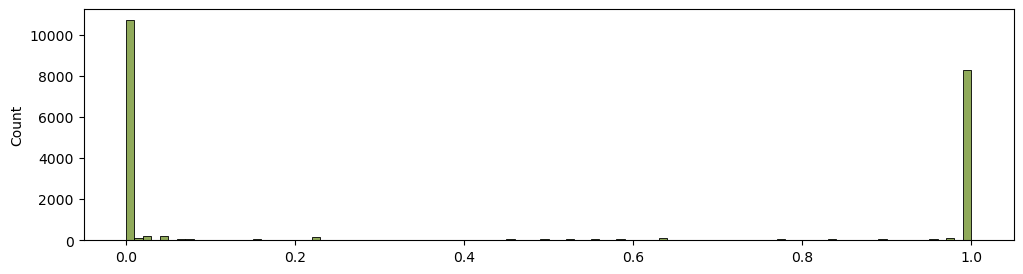

In [33]:
calibrated_model = CalibratedClassifierCV(lgbm_model, cv='prefit', method='isotonic')
calibrated_model.fit(X_train, y_train)

calibrated_pred_proba = calibrated_model.predict_proba(X_test)[:,1]
binned_true_p, binned_predict_p = calibration_curve(y_test, calibrated_pred_proba, n_bins=5)


plt.figure(figsize=(6, 6))
plt.plot(binned_predict_p, binned_true_p, marker='o', linewidth=1, label='LGBM Model', color = color_1)
plt.plot([0, 1], [0, 1], linestyle='--', color=color_2, label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (After Calibration)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 3))
sns.histplot(calibrated_pred_proba, bins=100, color=color_2)
plt.show()

### Training SHAP

In [34]:
# Initialize the SHAP explainer
explainer = shap.Explainer(lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


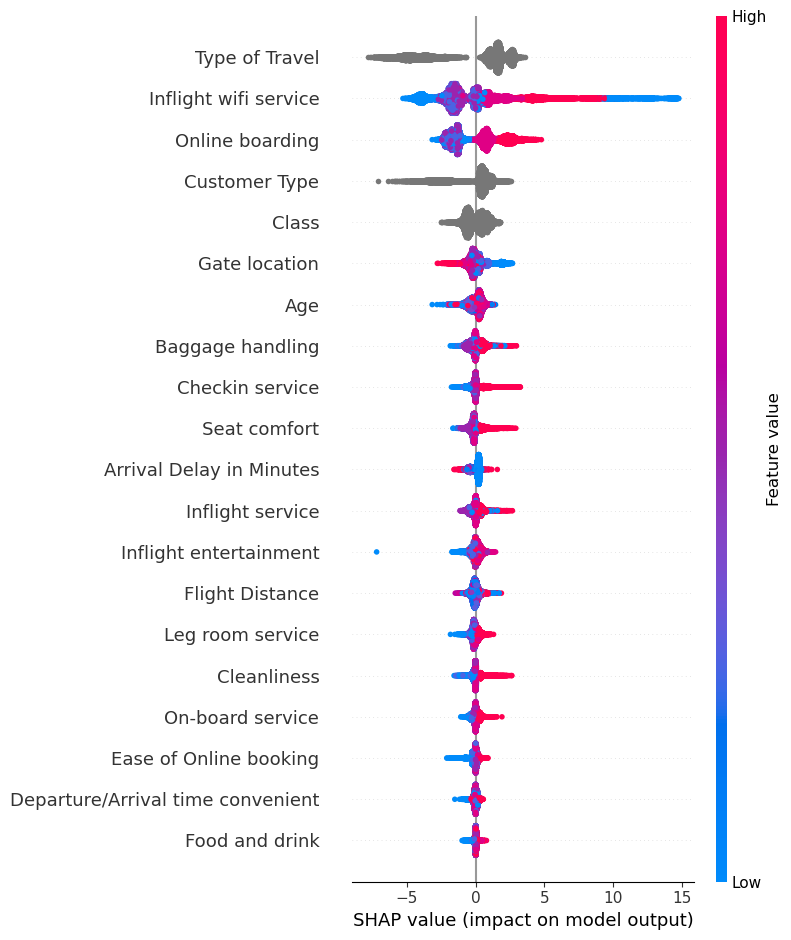

In [35]:
# Summary plot of feature importance
plt.figure(figsize=(4, 4))
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

In [36]:
shap_display_cols = ['Age', 'Flight Distance', 'Arrival Delay in Minutes','Departure Delay in Minutes',]

<Figure size 1200x400 with 0 Axes>

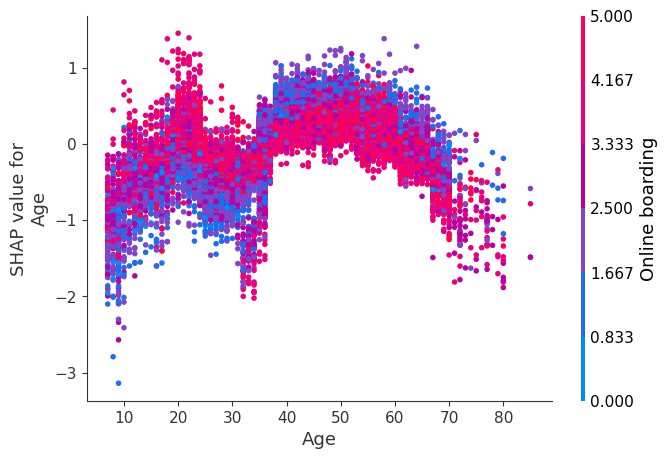

<Figure size 1200x400 with 0 Axes>

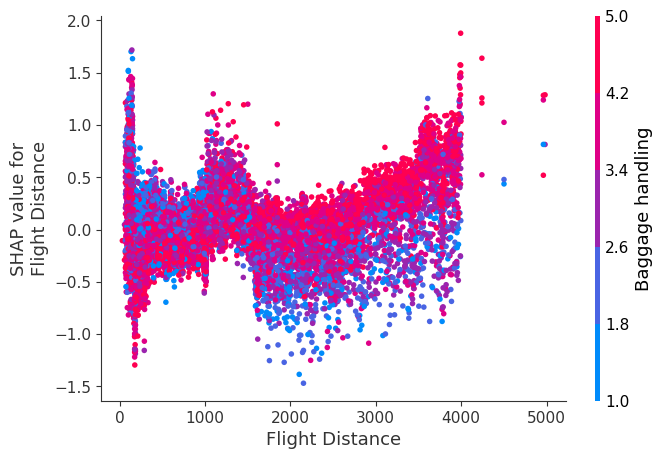

<Figure size 1200x400 with 0 Axes>

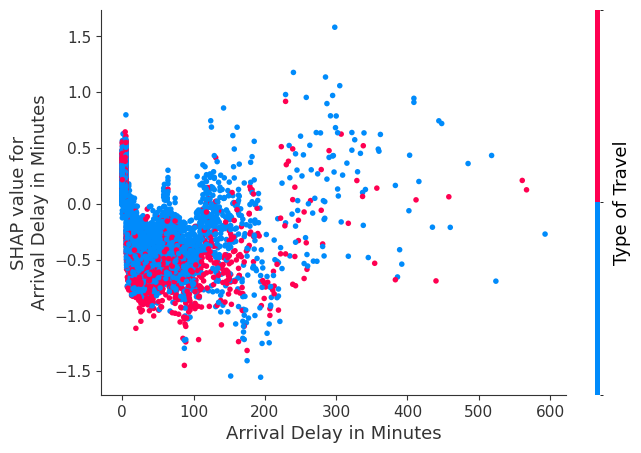

<Figure size 1200x400 with 0 Axes>

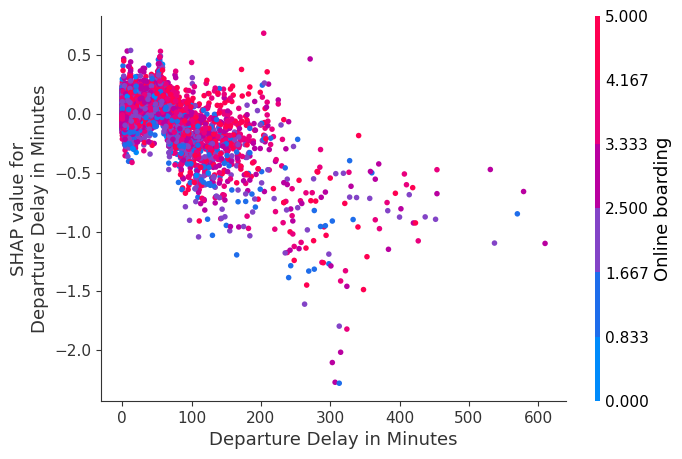

In [37]:
# Iterate through each feature name in numerical_features
for feature in shap_display_cols:
    plt.figure(figsize=(12, 4))
    shap.dependence_plot(feature, shap_values, X_test, feature_names=X_test.columns)
    plt.show()


In [38]:
# Grab SHAP values for each prediction
shap_df = pd.DataFrame(shap_values, columns=[f'{col}_SHAP' for col in X_test.columns], index=X_test.index)

# It's good practice to keep the original (or scaled) features alongside their SHAP values
X_test_with_shap = pd.concat([X_test, shap_df], axis=1)

# Also add the actual satisfaction from y_test for analysis
X_test_with_shap['satisfaction'] = y_test

X_test_with_shap['Pred'] = y_pred
X_test_with_shap['Pred Proba'] = calibrated_pred_proba

X_test_with_shap

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP,satisfaction,Pred,Pred Proba
81011,Male,Loyal Customer,39,Business travel,Business,760,3,3,3,3,3,4,4,5,5,5,5,5,5,4,0,0.0,0.031522,1.173432,0.143584,2.609593,0.745053,-0.225339,0.165762,0.101952,-0.065862,0.086272,0.008850,0.809091,-0.044741,0.279770,0.283853,0.272541,0.498755,0.711590,0.343576,0.018349,-0.018929,0.135966,1,1,1.000000
31920,Female,Loyal Customer,53,Business travel,Eco,598,4,2,2,2,4,3,3,4,4,4,4,2,4,4,0,0.0,-0.020748,0.513387,0.058664,1.051737,-0.468659,-0.016725,1.256070,0.018726,-0.106251,-0.133893,0.019307,-1.866829,-0.473932,0.259223,0.047784,-0.051013,-0.141394,-0.376479,-0.170930,-0.096870,-0.036911,0.244328,1,0,0.062176
9054,Female,Loyal Customer,20,Business travel,Business,1590,3,4,4,4,3,3,3,3,4,2,3,4,3,3,0,0.0,-0.028183,0.422160,-0.037404,1.466136,0.129342,-0.054759,-1.602701,-0.188309,-0.040388,-0.884047,-0.032321,-2.308049,-0.503737,-0.144306,0.035223,-0.098868,-0.741082,-0.206724,-0.586288,-0.021435,0.019510,0.179640,0,0,0.000000
55456,Female,Loyal Customer,33,Personal Travel,Eco,1310,2,5,2,3,5,2,5,5,5,3,3,4,4,5,24,12.0,-0.044977,0.622495,-0.252478,-4.944666,-0.680654,0.215627,-1.580376,-0.201421,-0.070456,-0.090580,0.049567,-1.349982,0.117134,-0.120289,0.483014,-0.171230,-0.307000,-0.071613,0.020977,0.393183,-0.018704,-0.283133,0,0,0.000000
7836,Female,Loyal Customer,52,Business travel,Eco,1262,4,3,3,3,1,2,3,4,4,4,4,1,4,2,31,37.0,0.004476,0.493792,0.460629,1.160272,-0.340179,0.116573,1.730493,0.025379,0.037117,-0.317568,-0.121409,-1.156071,-0.542387,0.264023,0.019300,-0.030250,-0.125579,-0.427878,-0.125827,-0.207081,0.094500,-0.628418,0,0,0.553030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71470,Female,Loyal Customer,39,Business travel,Business,325,3,3,3,3,5,4,5,5,5,5,5,5,5,5,0,0.0,-0.024586,1.207794,0.139551,2.666609,0.746896,-0.292186,0.157616,0.118246,-0.067068,0.048298,0.008707,0.697551,0.360598,0.197727,0.290968,0.256199,0.344285,0.547460,0.194219,0.328283,-0.005865,0.136310,1,1,1.000000
66622,Male,Loyal Customer,39,Business travel,Eco,265,5,4,3,4,5,4,5,5,2,5,5,1,1,5,0,0.0,0.003274,0.672585,0.157594,0.974953,-0.357972,0.053349,3.664765,-0.032773,-0.130822,-0.047643,-0.049435,0.145511,0.261879,-0.240751,-0.228692,0.320449,1.129250,-0.434378,1.097057,0.388949,0.051582,0.232862,1,1,1.000000
20776,Female,Loyal Customer,44,Business travel,Business,2521,5,5,5,5,5,4,4,5,5,5,5,4,5,3,37,47.0,-0.167758,0.317811,0.259450,0.939882,0.180523,0.078559,4.187633,0.305940,0.159494,-0.291842,0.034684,0.623077,-0.159376,-0.346652,0.281494,0.765384,0.541436,0.010677,0.490476,0.063084,0.091023,-0.092796,1,1,1.000000
24263,Male,Loyal Customer,61,Business travel,Eco,109,5,4,4,4,5,5,5,5,2,5,2,2,5,5,29,29.0,0.008196,0.572137,-0.120509,1.335118,-0.263169,1.162044,4.219641,-0.073855,0.001043,-0.140630,0.021675,2.787134,0.271969,0.093776,-0.259122,0.228264,0.445011,-0.230441,0.854870,0.386691,-0.019564,-0.649916,1,1,1.000000


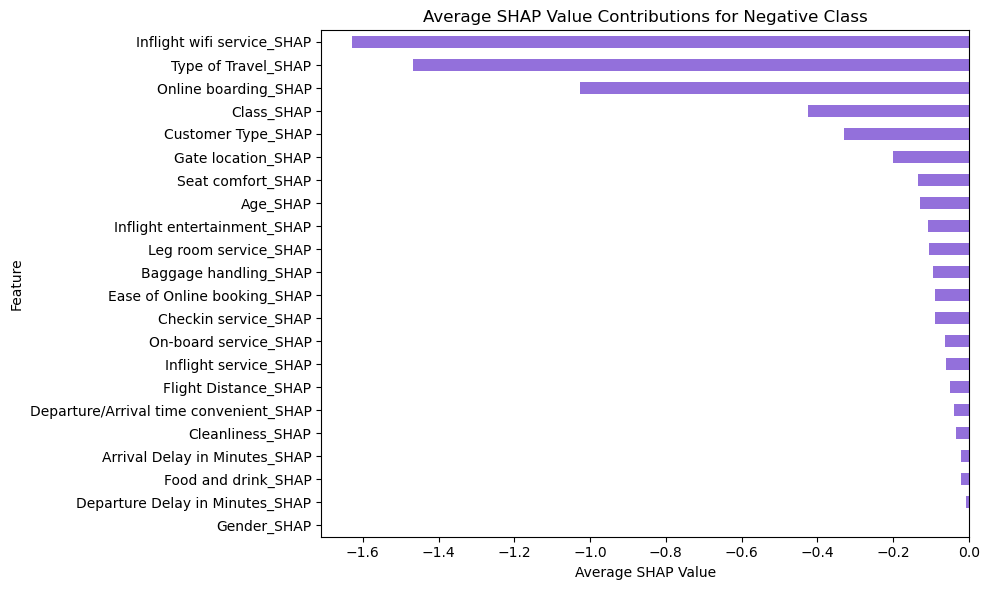

In [39]:
# Filter for positive and negative class
positive_class = X_test_with_shap[X_test_with_shap['satisfaction'] == 1]
neg_class = X_test_with_shap[X_test_with_shap['satisfaction'] == 0]

# Select only the SHAP value columns
shap_value_columns = [col for col in positive_class.columns if col.endswith('_SHAP')]
positive_class = positive_class[shap_value_columns]
neg_class = neg_class[shap_value_columns]

# Calculate the average SHAP value for each feature among negative class
neg_class = neg_class.mean()
# You can even visualize this
plt.figure(figsize=(10, 6))
neg_class.sort_values(ascending=False).plot(kind='barh', color=color_1)
plt.title(f'Average SHAP Value Contributions for Negative Class')
plt.xlabel('Average SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [40]:
neg_class.sort_values(ascending=True).round(2).head(10)

Inflight wifi service_SHAP    -1.63
Type of Travel_SHAP           -1.47
Online boarding_SHAP          -1.03
Class_SHAP                    -0.42
Customer Type_SHAP            -0.33
Gate location_SHAP            -0.20
Seat comfort_SHAP             -0.14
Age_SHAP                      -0.13
Inflight entertainment_SHAP   -0.11
Leg room service_SHAP         -0.11
dtype: float64

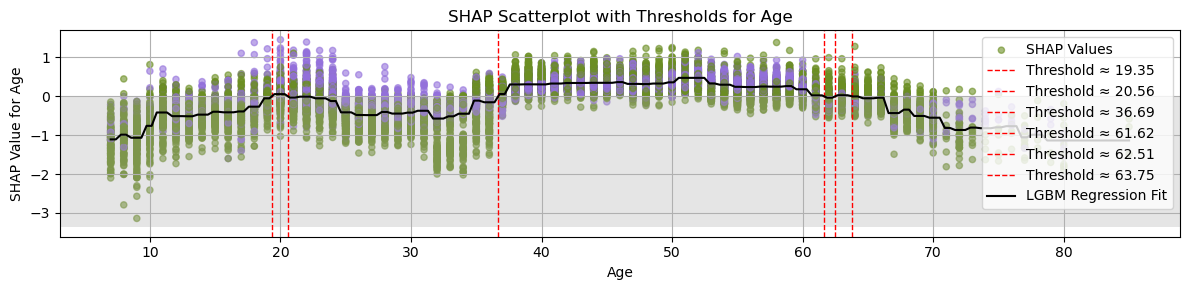

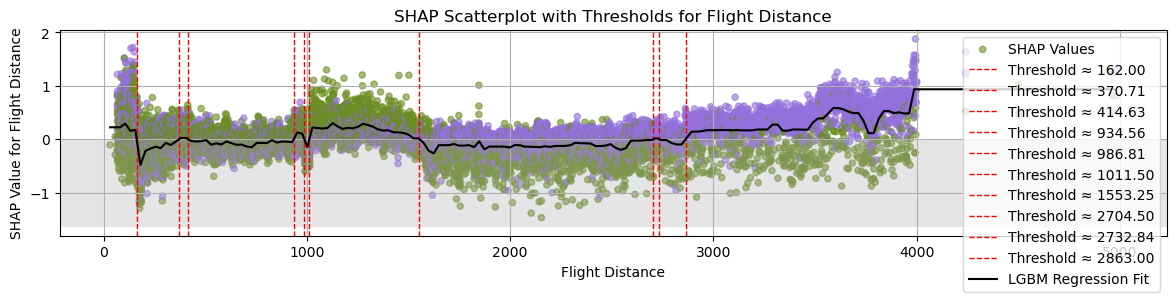

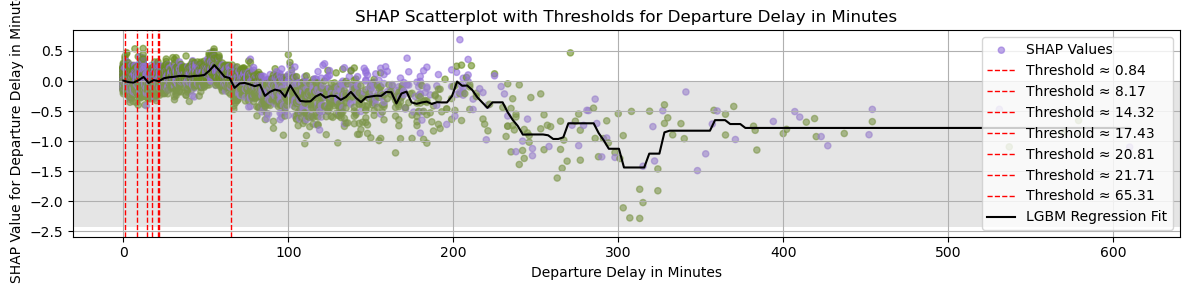

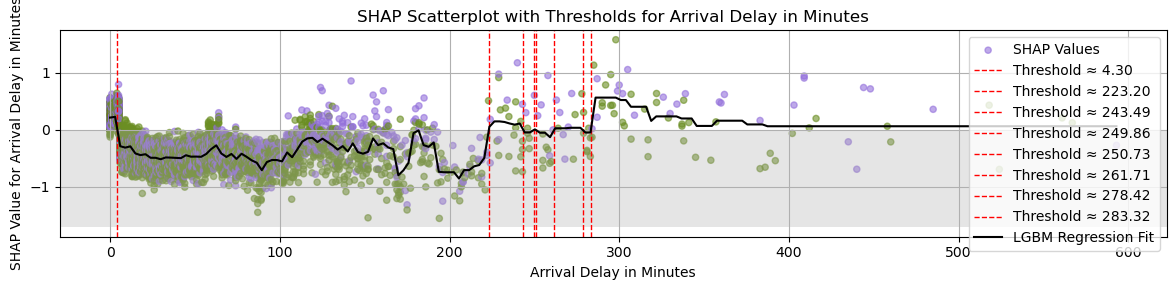

In [41]:

thresholds = {}

# Iterate through each feature
for i, feature_name in enumerate(X_test.columns):
    if feature_name not in categorical_features and feature_name in shap_display_cols:

        # SHAP values for the current feature
        feature_values = X_test[feature_name].values
        shap_feature_values = shap_values[:, i]

        # Determine colors based on 'Quality'
        colors = np.where(y_test == 1, color_1, color_2)

        # Sort data for plotting and fitting
        sorted_indices = np.argsort(feature_values.flatten())
        sorted_feature_values = feature_values[sorted_indices]
        sorted_shap_feature_values = shap_feature_values[sorted_indices]
        sorted_colors = colors[sorted_indices]

        # Convert sorted_feature_values to a DataFrame for the regressor
        X_fit_regressor = pd.DataFrame(sorted_feature_values.reshape(-1, 1), columns=[feature_name])

        # Fit a small LightGBMRegressor
        lgbm_reg = lgb.LGBMRegressor(objective='regression', n_estimators=50, learning_rate=0.1, random_state=42, silent=True)
        lgbm_reg.fit(X_fit_regressor, sorted_shap_feature_values)

        # Predict SHAP value for a range of feature values
        feature_range_values = np.linspace(sorted_feature_values.min(), sorted_feature_values.max(), 200)
        X_predict_regressor = pd.DataFrame(feature_range_values.reshape(-1, 1), columns=[feature_name])
        predicted_shap = lgbm_reg.predict(X_predict_regressor)

        # Find approximate zero-crossing points
        zero_crossings = []
        sign_changes = np.where(np.diff(np.sign(predicted_shap)))[0]
        for idx in sign_changes:
            # Linear interpolation to approximate the zero-crossing value
            x1, y1 = feature_range_values[idx], predicted_shap[idx]
            x2, y2 = feature_range_values[idx + 1], predicted_shap[idx + 1]
            if y1 * y2 < 0:  # Ensure a sign change occurred
                zero_crossing = x1 - y1 * (x2 - x1) / (y2 - y1)
                zero_crossings.append(zero_crossing)

        # Store the results
        thresholds[feature_name] = {
            'Predicted Thresholds': zero_crossings,
            'Mean': X_test[feature_name].mean(),
            'Median': X_test[feature_name].median()
        }

        # Create the DataFrame from the dictionary
        results_df = pd.DataFrame.from_dict(thresholds, orient='index')

        # Plot the SHAP Threshold Scatterplot
        plt.figure(figsize=(12, 3))
        plt.scatter(sorted_feature_values, sorted_shap_feature_values, s=20, c=sorted_colors, alpha=0.6, label='SHAP Values')
        # Add red vertical lines for each zero crossing
        for crossing in zero_crossings:
            plt.axvline(x=crossing, color='red', linestyle='--', linewidth=1, label=f'Threshold ≈ {crossing:.2f}')
        y_min, y_max = plt.ylim()
        plt.axhspan(y_min, 0, facecolor='darkgrey', alpha=0.3)
        plt.plot(feature_range_values, predicted_shap, color='black', linestyle='-', label='LGBM Regression Fit')
        plt.xlabel(feature_name)
        plt.ylabel(f'SHAP Value for {feature_name}')
        plt.title(f'SHAP Scatterplot with Thresholds for {feature_name}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [42]:
# Print the DataFrame with all zero-crossing points
print("DataFrame of Predicted Thresholds:")
results_df['Predicted Thresholds'] = results_df['Predicted Thresholds'].apply(lambda x: [val.round(2) for val in x])
results_df.round(2)

DataFrame of Predicted Thresholds:


,Predicted Thresholds,Mean,Median
Age,"[19.35, 20.56, 36.69, 61.62, 62.51, 63.75]",39.53,40.0
Flight Distance,"[162.0, 370.71, 414.63, 934.56, 986.81, 1011.5...",1192.58,849.0
Departure Delay in Minutes,"[0.84, 8.17, 14.32, 17.43, 20.81, 21.71, 65.31]",14.67,0.0
Arrival Delay in Minutes,"[4.3, 223.2, 243.49, 249.86, 250.73, 261.71, 2...",15.01,0.0


### Training Cohorts

In [43]:
conditions = [
                X_test_with_shap['Age'] < 20, 
                X_test_with_shap['Age'] < 25, 
                X_test_with_shap['Age'] < 38, 
                X_test_with_shap['Age'] < 62, 
            ]

choices = [
            'Under 20', 
            '20 to 25', 
            '26 to 37', 
            '38 to 62', 
        ]

X_test_with_shap['Age Cohort'] = np.select(conditions, choices, 'Over 62')

In [44]:
X_test_with_shap

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP,satisfaction,Pred,Pred Proba,Age Cohort
81011,Male,Loyal Customer,39,Business travel,Business,760,3,3,3,3,3,4,4,5,5,5,5,5,5,4,0,0.0,0.031522,1.173432,0.143584,2.609593,0.745053,-0.225339,0.165762,0.101952,-0.065862,0.086272,0.008850,0.809091,-0.044741,0.279770,0.283853,0.272541,0.498755,0.711590,0.343576,0.018349,-0.018929,0.135966,1,1,1.000000,38 to 62
31920,Female,Loyal Customer,53,Business travel,Eco,598,4,2,2,2,4,3,3,4,4,4,4,2,4,4,0,0.0,-0.020748,0.513387,0.058664,1.051737,-0.468659,-0.016725,1.256070,0.018726,-0.106251,-0.133893,0.019307,-1.866829,-0.473932,0.259223,0.047784,-0.051013,-0.141394,-0.376479,-0.170930,-0.096870,-0.036911,0.244328,1,0,0.062176,38 to 62
9054,Female,Loyal Customer,20,Business travel,Business,1590,3,4,4,4,3,3,3,3,4,2,3,4,3,3,0,0.0,-0.028183,0.422160,-0.037404,1.466136,0.129342,-0.054759,-1.602701,-0.188309,-0.040388,-0.884047,-0.032321,-2.308049,-0.503737,-0.144306,0.035223,-0.098868,-0.741082,-0.206724,-0.586288,-0.021435,0.019510,0.179640,0,0,0.000000,20 to 25
55456,Female,Loyal Customer,33,Personal Travel,Eco,1310,2,5,2,3,5,2,5,5,5,3,3,4,4,5,24,12.0,-0.044977,0.622495,-0.252478,-4.944666,-0.680654,0.215627,-1.580376,-0.201421,-0.070456,-0.090580,0.049567,-1.349982,0.117134,-0.120289,0.483014,-0.171230,-0.307000,-0.071613,0.020977,0.393183,-0.018704,-0.283133,0,0,0.000000,26 to 37
7836,Female,Loyal Customer,52,Business travel,Eco,1262,4,3,3,3,1,2,3,4,4,4,4,1,4,2,31,37.0,0.004476,0.493792,0.460629,1.160272,-0.340179,0.116573,1.730493,0.025379,0.037117,-0.317568,-0.121409,-1.156071,-0.542387,0.264023,0.019300,-0.030250,-0.125579,-0.427878,-0.125827,-0.207081,0.094500,-0.628418,0,0,0.553030,38 to 62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71470,Female,Loyal Customer,39,Business travel,Business,325,3,3,3,3,5,4,5,5,5,5,5,5,5,5,0,0.0,-0.024586,1.207794,0.139551,2.666609,0.746896,-0.292186,0.157616,0.118246,-0.067068,0.048298,0.008707,0.697551,0.360598,0.197727,0.290968,0.256199,0.344285,0.547460,0.194219,0.328283,-0.005865,0.136310,1,1,1.000000,38 to 62
66622,Male,Loyal Customer,39,Business travel,Eco,265,5,4,3,4,5,4,5,5,2,5,5,1,1,5,0,0.0,0.003274,0.672585,0.157594,0.974953,-0.357972,0.053349,3.664765,-0.032773,-0.130822,-0.047643,-0.049435,0.145511,0.261879,-0.240751,-0.228692,0.320449,1.129250,-0.434378,1.097057,0.388949,0.051582,0.232862,1,1,1.000000,38 to 62
20776,Female,Loyal Customer,44,Business travel,Business,2521,5,5,5,5,5,4,4,5,5,5,5,4,5,3,37,47.0,-0.167758,0.317811,0.259450,0.939882,0.180523,0.078559,4.187633,0.305940,0.159494,-0.291842,0.034684,0.623077,-0.159376,-0.346652,0.281494,0.765384,0.541436,0.010677,0.490476,0.063084,0.091023,-0.092796,1,1,1.000000,38 to 62
24263,Male,Loyal Customer,61,Business travel,Eco,109,5,4,4,4,5,5,5,5,2,5,2,2,5,5,29,29.0,0.008196,0.572137,-0.120509,1.335118,-0.263169,1.162044,4.219641,-0.073855,0.001043,-0.140630,0.021675,2.787134,0.271969,0.093776,-0.259122,0.228264,0.445011,-0.230441,0.854870,0.386691,-0.019564,-0.649916,1,1,1.000000,38 to 62


In [45]:
shap_columns = [col for col in X_test_with_shap.columns if col.endswith('_SHAP')]

In [46]:
cohort_list = ['Age Cohort', 'Gender', 'Customer Type', 'Type of Travel', 'Class']

# Create the dictionary for aggregation
agg_dict = {col: 'mean' for col in numerical_features}
agg_dict.update({col: 'mean' for col in ['Pred Proba']})
agg_dict.update({col: lambda x: x.mode()[0] for col in categorical_features if col not in cohort_list})
agg_dict.update({col: 'mean' for col in shap_columns})

# Group by
X_test_cohort_shap = X_test_with_shap.groupby(cohort_list).agg(agg_dict).dropna().sort_values(by='Pred Proba',ascending=False).reset_index()

X_test_cohort_shap

/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_7699/3553147071.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test_cohort_shap = X_test_with_shap.groupby(cohort_list).agg(agg_dict).dropna().sort_values(by='Pred Proba',ascending=False).reset_index()


,Age Cohort,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Pred Proba,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP
0,38 to 62,Female,disloyal Customer,Personal Travel,Business,53.000000,2475.000000,4.000000,5.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,4.000000,2.000000,5.000000,3.000000,5.000000,1.000000,0.000000,0.000000,0.962963,0.019009,-1.137236,0.680473,-2.418199,0.128041,0.369712,1.904551,0.222556,0.208280,0.110534,-0.020844,0.630741,0.188414,-0.090165,-0.003468,-0.089417,0.442551,0.082473,0.338813,-0.172883,-0.077271,0.299424
1,Under 20,Female,disloyal Customer,Personal Travel,Eco,13.500000,1283.500000,4.500000,5.000000,4.500000,2.000000,3.000000,4.500000,1.500000,3.000000,3.500000,3.500000,4.000000,5.000000,4.000000,3.000000,2.500000,0.000000,0.947802,0.031805,-0.801758,0.045979,-2.048562,-0.546286,0.508147,6.106094,0.093512,0.366684,0.146125,-0.003915,1.318648,-0.004935,0.067728,0.035744,-0.023320,-0.102456,0.503973,0.044362,0.013045,-0.032152,0.336623
2,20 to 25,Male,disloyal Customer,Business travel,Business,22.276596,729.180851,3.542553,1.702128,3.531915,2.808511,3.351064,3.500000,3.212766,3.372340,3.797872,3.500000,4.404255,3.829787,4.244681,3.351064,18.351064,16.085106,0.871796,0.017775,-1.496028,0.440447,0.934032,0.638013,-0.036580,4.386297,-0.066464,0.129505,-0.129653,0.001335,0.856780,-0.014485,0.001770,0.076201,-0.025918,0.221417,0.156910,0.149665,0.017689,-0.002725,-0.005623
3,Under 20,Female,disloyal Customer,Business travel,Business,14.300000,959.000000,2.300000,1.350000,2.250000,2.750000,3.250000,2.350000,3.450000,3.450000,3.550000,3.850000,4.150000,3.700000,4.300000,3.350000,13.550000,12.100000,0.850000,-0.022659,-1.768025,0.033058,0.953445,0.646622,0.077014,6.019082,-0.146240,-0.139662,-0.118691,-0.013098,-0.090522,0.027996,0.022989,0.051111,0.018450,0.038088,0.117240,0.205123,-0.006656,-0.034428,0.118464
4,38 to 62,Male,Loyal Customer,Business travel,Business,48.469809,1874.825847,2.814065,2.975331,2.941826,3.036082,3.362666,4.056333,4.094256,3.884389,3.874816,3.908689,3.884389,3.629602,3.877761,3.640280,13.511046,13.681885,0.843739,0.028139,0.767966,0.311931,1.915415,0.553943,0.036333,1.159806,0.086188,-0.043811,0.378750,0.015713,0.922459,0.155866,0.175840,0.090921,0.074032,0.089693,0.147754,0.054432,0.122788,-0.003039,0.022309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Under 20,Female,disloyal Customer,Business travel,Eco Plus,12.750000,1190.375000,2.375000,1.375000,2.250000,3.375000,3.000000,2.750000,3.625000,3.125000,3.250000,2.750000,3.250000,2.625000,3.375000,3.500000,5.875000,10.625000,0.000000,-0.032882,-2.402679,-0.436988,1.305489,-0.751119,0.155234,-1.876750,-0.094975,-0.033589,-0.122458,-0.056689,-1.263626,-0.030687,0.010423,0.020354,-0.052039,-0.249533,-0.086699,-0.278197,-0.002249,0.018700,-0.058443
99,Over 62,Female,disloyal Customer,Business travel,Eco Plus,65.250000,690.250000,1.750000,1.750000,1.750000,2.750000,2.250000,1.750000,1.500000,2.250000,2.500000,2.250000,4.250000,2.500000,3.750000,2.250000,31.500000,25.500000,0.000000,-0.010391,-2.496437,0.079919,1.407094,-0.734846,-0.0

In [47]:
# Apply the function to each row
X_test_cohort_shap[['Top Positive Features', 'Top Negative Features']] = X_test_cohort_shap[shap_columns].apply(get_top_bottom_n_columns, 
                                                                                                            axis=1, 
                                                                                                            result_type='expand')

In [48]:
# Create a list of columns that end with '_SHAP'
shap_columns = [col for col in X_test_cohort_shap.columns if col.endswith('_SHAP')]

# Define the number of decimal places to round to
decimals = 3

# Loop through the identified columns and round them
for col in shap_columns:
    X_test_cohort_shap[col] = X_test_cohort_shap[col].round(decimals)

X_test_cohort_shap['Pred Proba'] = X_test_cohort_shap['Pred Proba'].round(decimals)

In [49]:
X_test_cohort_shap.head(10)

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Pred Proba,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP,Top Positive Features,Top Negative Features
0,38 to 62,Female,disloyal Customer,Personal Travel,Business,53.000000,2475.000000,4.000000,5.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,4.000000,2.000000,5.000000,3.000000,5.000000,1.000000,0.000000,0.000000,0.963,0.019,-1.137,0.680,-2.418,0.128,0.370,1.905,0.223,0.208,0.111,-0.021,0.631,0.188,-0.090,-0.003,-0.089,0.443,0.082,0.339,-0.173,-0.077,0.299,"[Inflight wifi service, Age, Online boarding, ...","[Type of Travel, Customer Type, Cleanliness, I..."
1,Under 20,Female,disloyal Customer,Personal Travel,Eco,13.500000,1283.500000,4.500000,5.000000,4.500000,2.000000,3.000000,4.500000,1.500000,3.000000,3.500000,3.500000,4.000000,5.000000,4.000000,3.000000,2.500000,0.000000,0.948,0.032,-0.802,0.046,-2.049,-0.546,0.508,6.106,0.094,0.367,0.146,-0.004,1.319,-0.005,0.068,0.036,-0.023,-0.102,0.504,0.044,0.013,-0.032,0.337,"[Inflight wifi service, Online boarding, Fligh...","[Type of Travel, Customer Type, Class, Baggage..."
2,20 to 25,Male,disloyal Customer,Business travel,Business,22.276596,729.180851,3.542553,1.702128,3.531915,2.808511,3.351064,3.500000,3.212766,3.372340,3.797872,3.500000,4.404255,3.829787,4.244681,3.351064,18.351064,16.085106,0.872,0.018,-1.496,0.440,0.934,0.638,-0.037,4.386,-0.066,0.130,-0.130,0.001,0.857,-0.014,0.002,0.076,-0.026,0.221,0.157,0.150,0.018,-0.003,-0.006,"[Inflight wifi service, Type of Travel, Online...","[Customer Type, Gate location, Departure/Arriv..."
3,Under 20,Female,disloyal Customer,Business travel,Business,14.300000,959.000000,2.300000,1.350000,2.250000,2.750000,3.250000,2.350000,3.450000,3.450000,3.550000,3.850000,4.150000,3.700000,4.300000,3.350000,13.550000,12.100000,0.850,-0.023,-1.768,0.033,0.953,0.647,0.077,6.019,-0.146,-0.140,-0.119,-0.013,-0.091,0.028,0.023,0.051,0.018,0.038,0.117,0.205,-0.007,-0.034,0.118,"[Inflight wifi service, Type of Travel, Class,...","[Customer Type, Departure/Arrival time conveni..."
4,38 to 62,Male,Loyal Customer,Business travel,Business,48.469809,1874.825847,2.814065,2.975331,2.941826,3.036082,3.362666,4.056333,4.094256,3.884389,3.874816,3.908689,3.884389,3.629602,3.877761,3.640280,13.511046,13.681885,0.844,0.028,0.768,0.312,1.915,0.554,0.036,1.160,0.086,-0.044,0.379,0.016,0.922,0.156,0.176,0.091,0.074,0.090,0.148,0.054,0.123,-0.003,0.022,"[Type of Travel, Inflight wifi service, Online...","[Ease of Online booking, Departure Delay in Mi..."
5,38 to 62,Female,Loyal Customer,Business travel,Business,48.759140,1849.802867,2.751254,2.927957,2.909677,2.976344,3.370251,4.046953,4.071326,3.874194,3.859857,3.906452,3.888889,3.595341,3.873477,3.659498,14.033692,14.227240,0.836,-0.025,0.791,0.321,1.954,0.570,0.014,1.032,0.080,-0.037,0.399,0.014,0.895,0.135,0.170,0.090,0.071,0.104,0.132,0.066,0.126,0.002,0.014,"[Type of Travel, Inflight wifi service, Online...","[Ease of Online booking, Gender, Departure Del..."
6,Under 20,Male,disloyal Customer,Business travel,Business,15.200000,993.600000,3.360000,1.720000,3.320000,3.120000,3.000000,2.960000,3.040000,3.000000,3.240000,3.160000,4.240000,3.880000,4.200000,2.960000,15.320000,15.520000,0.792,0.007,-1.

### Prediction

In [50]:
X_train = pd.concat([X_train, X_test])
y_train = pd.concat([y_train, y_test])

print(f'X_train: {len(X_train)}')
print(f'X: {len(X)}')

X_train: 103904
X: 25976


In [51]:
# Parameters for the current model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',
    'n_estimators':best_n_estimators,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'scale_pos_weight': 0.5,
    'n_jobs': -1,
    'verbose': -1,
}

In [52]:
# Initialize the LightGBMClassifier
lgbm_model = lgb.LGBMClassifier(**best_params)

lgbm_model.fit(X_train, y_train,
                categorical_feature=categorical_features,
                )

# Make predictions on the test set
y_pred = lgbm_model.predict(X)
y_pred_proba = lgbm_model.predict_proba(X)[:, 1]

### Prediction Calibrate Predicted Probability

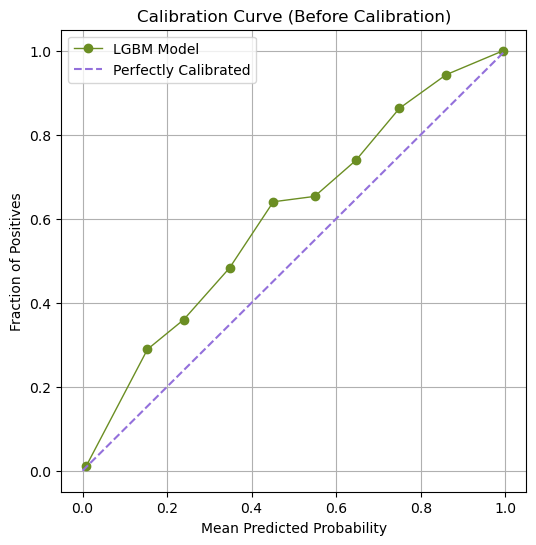

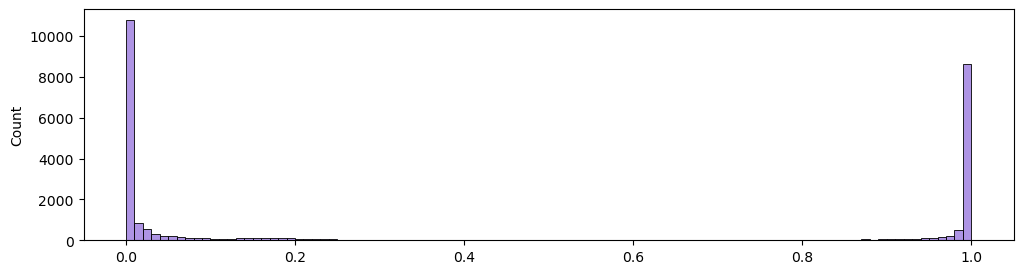

In [54]:
calibrated_pred_proba = lgbm_model.predict_proba(X)[:,1]
binned_true_p, binned_predict_p = calibration_curve(y, calibrated_pred_proba, n_bins=10)


plt.figure(figsize=(6, 6))
plt.plot(binned_predict_p, binned_true_p, marker='o', linewidth=1, label='LGBM Model', color = color_2)
plt.plot([0, 1], [0, 1], linestyle='--', color=color_1, label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Before Calibration)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


plt.figure(figsize = (12, 3))
sns.histplot(calibrated_pred_proba, bins=100, color=color_1)
plt.show()

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


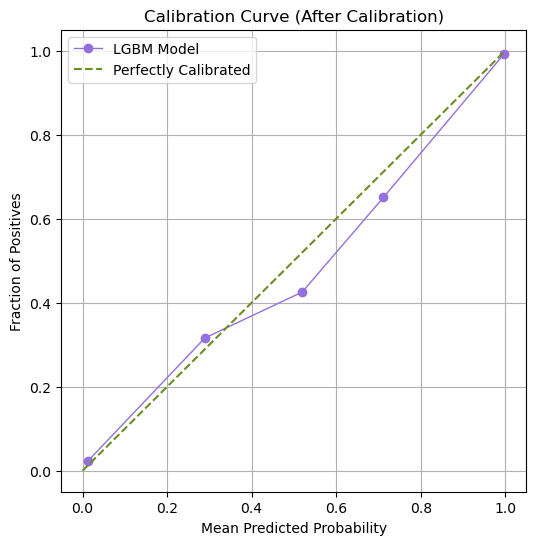

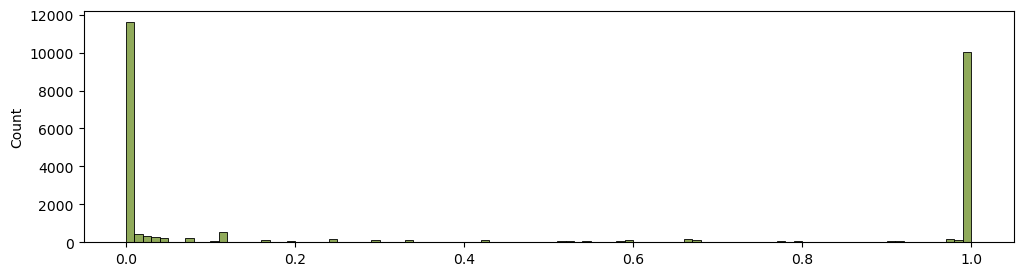

In [55]:
calibrated_model = CalibratedClassifierCV(lgbm_model, cv='prefit', method='isotonic')
calibrated_model.fit(X_train, y_train)

calibrated_pred_proba = calibrated_model.predict_proba(X)[:,1]
binned_true_p, binned_predict_p = calibration_curve(y, calibrated_pred_proba, n_bins=5)


plt.figure(figsize=(6, 6))
plt.plot(binned_predict_p, binned_true_p, marker='o', linewidth=1, label='LGBM Model', color = color_1)
plt.plot([0, 1], [0, 1], linestyle='--', color=color_2, label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (After Calibration)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 3))
sns.histplot(calibrated_pred_proba, bins=100, color=color_2)
plt.show()

### Prediction SHAP

In [56]:
# Initialize the SHAP explainer
explainer = shap.Explainer(lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

/Users/sam/opt/anaconda3/envs/lgbm_env/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


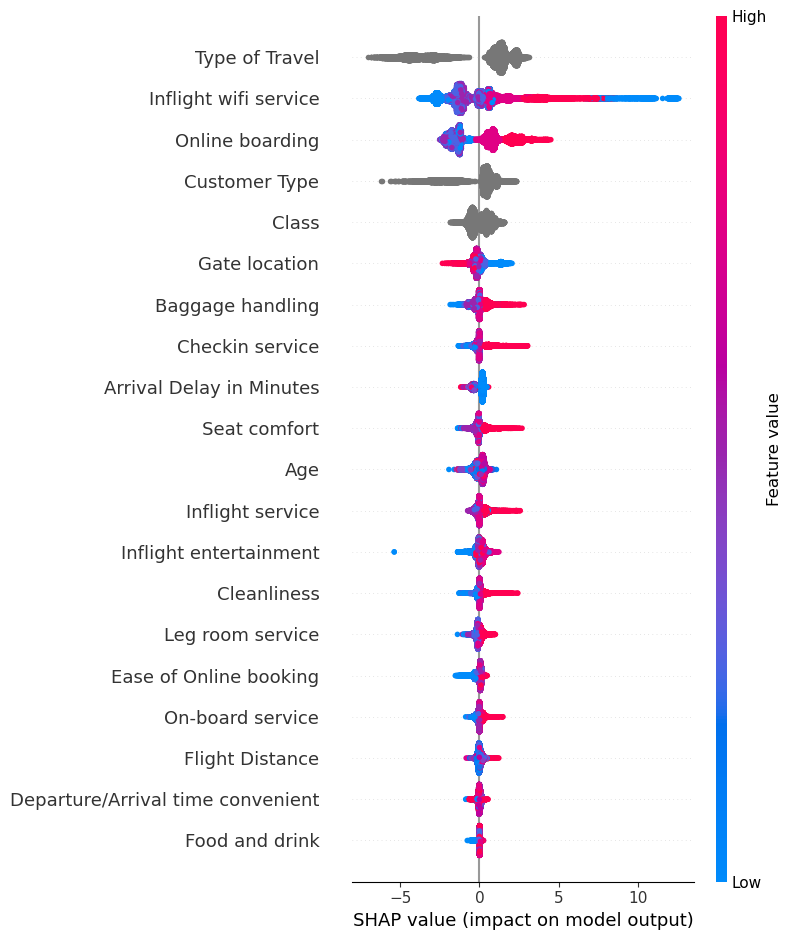

In [57]:
# Summary plot of feature importance
plt.figure(figsize=(4, 4))
shap.summary_plot(shap_values, X, feature_names=X.columns)
plt.show()

In [58]:
# Grab SHAP values for each prediction
shap_df = pd.DataFrame(shap_values, columns=[f'{col}_SHAP' for col in X.columns], index=X.index)

# It's good practice to keep the original (or scaled) features alongside their SHAP values
X_with_shap = pd.concat([X, shap_df], axis=1)

X_with_shap['Pred'] = y_pred
X_with_shap['Pred Proba'] = calibrated_pred_proba

X_with_shap

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP,Pred,Pred Proba
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0.003571,0.570311,0.247203,1.002790,-0.304165,-0.025804,3.171108,-0.037887,-0.089321,-0.219948,0.017798,0.267557,-0.173106,-0.033815,0.320038,0.353243,0.550901,-0.271664,0.453324,0.421246,0.005116,-0.394817,1,1.000000
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0.001475,1.101863,-0.220369,1.967294,0.879812,0.177500,0.717355,0.107400,-0.047133,1.728160,0.056646,0.976681,0.688088,0.346803,0.142441,0.192497,0.091813,-0.029902,-0.030058,0.484698,-0.017811,0.277934,1,1.000000
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,-0.008453,-1.609337,-0.111228,1.150083,-0.388365,-0.052809,-1.461544,-0.233866,-0.119430,-0.240353,-0.016594,-1.751083,-0.080312,-0.045221,-0.007373,-0.099539,-0.353128,-0.208763,0.038918,-0.109016,-0.003245,0.183688,0,0.000000
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,-0.001785,0.277349,0.123823,0.758112,0.223477,0.019520,8.478497,-0.147865,-0.659830,0.211944,-0.004268,0.301591,-0.067728,-0.706977,-0.230254,-0.446507,-0.124283,-0.036590,-0.109862,0.133762,-0.004235,-0.295309,1,1.000000
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,0.004160,0.605530,0.353363,1.615133,-0.203686,0.096951,-1.001441,-0.007386,0.092876,-0.164269,0.016055,-1.598709,-0.400422,-0.036149,-0.131637,-0.121379,-0.302699,-0.130555,-0.201458,-0.014645,-0.048051,-0.412579,0,0.040404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,-0.000058,-3.558254,-1.027559,1.172861,0.424141,-0.008403,-1.181215,-0.014293,0.160616,0.210176,0.018701,-2.068635,-0.034002,0.196921,0.004890,-0.140935,0.006805,-0.003703,0.700331,0.007109,-0.011191,0.068602,0,0.000000
25972,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,-0.000616,0.560561,-0.076715,1.485754,0.405146,-0.100568,0.620817,-0.006813,0.014930,-0.170946,0.012315,1.005608,-0.102152,0.190403,0.003531,0.149808,0.421224,0.757592,0.430086,0.021267,-0.019366,0.159148,1,1.000000
25973,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,0.001384,0.436017,-0.329086,-4.297998,-0.267957,0.071688,-1.626502,-0.043520,-0.152593,-0.281517,-0.004546,-1.339959,-0.067403,-0.056796,-0.004465,-0.077598,-0.001430,0.803216,0.000284,-0.100072,0.005598,0.220713,0,0.000000
25974,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,-0.001297,0.812219,-0.003847,2.093729,0.624739,0.153459,-0.043068,0.103562,-0.012751,0.064666,0.055673,1.154692,-0.054567,0.385572,-0.060360,-0.297179,0.843826,-0.055652,0.749781,0.134435,-0.002100,0.189638,1,1.000000


### Prediction Cohorts

In [59]:
conditions = [
                X_with_shap['Age'] < 20, 
                X_with_shap['Age'] < 25, 
                X_with_shap['Age'] < 38, 
                X_with_shap['Age'] < 62, 
            ]

choices = [
            'Under 20', 
            '20 to 25', 
            '26 to 37', 
            '38 to 62', 
        ]

X_with_shap['Age Cohort'] = np.select(conditions, choices, 'Over 62')

In [60]:
shap_columns = [col for col in X_with_shap.columns if col.endswith('_SHAP')]

In [61]:

# Create the dictionary for aggregation
agg_dict = {col: 'mean' for col in numerical_features}
agg_dict.update({col: 'mean' for col in ['Pred Proba']})
agg_dict.update({col: lambda x: x.mode()[0] for col in categorical_features if col not in cohort_list})
agg_dict.update({col: 'mean' for col in shap_columns})
# agg_dict.update({col: 'mean' for col in shap_display_cols})

# Group by 
X_cohort_shap = X_with_shap.groupby(cohort_list).agg(agg_dict).dropna().sort_values(by='Pred Proba',ascending=False).reset_index()

X_cohort_shap

/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_7699/1448976149.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_cohort_shap = X_with_shap.groupby(cohort_list).agg(agg_dict).dropna().sort_values(by='Pred Proba',ascending=False).reset_index()


,Age Cohort,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Pred Proba,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP
0,Under 20,Female,disloyal Customer,Business travel,Business,15.200000,871.800000,3.200000,2.750000,3.350000,2.700000,2.300000,3.600000,2.250000,2.300000,4.100000,3.350000,4.650000,4.250000,4.400000,2.300000,11.000000,11.250000,0.997017,-0.000473,-1.475703,0.201927,0.785487,0.460149,0.037228,4.978058,-0.040053,-0.024991,-0.087514,-0.033615,1.301021,-0.072486,0.015285,0.117917,-0.016718,0.298835,0.230829,0.171416,-0.072094,0.033406,0.027835
1,20 to 25,Male,disloyal Customer,Business travel,Business,22.255474,678.357664,3.328467,1.934307,3.313869,2.963504,3.299270,3.160584,3.211679,3.299270,3.788321,3.379562,4.291971,3.729927,4.240876,3.240876,17.503650,18.291971,0.920834,-0.000553,-1.375502,0.320482,0.816595,0.528411,-0.008362,4.490118,-0.005450,0.013033,-0.118375,-0.006003,0.694273,0.003744,0.022792,0.083834,-0.033324,0.151780,0.092545,0.169522,0.000669,0.001888,0.014449
2,20 to 25,Female,disloyal Customer,Business travel,Business,22.326797,696.071895,3.555556,1.836601,3.535948,3.091503,3.130719,3.398693,3.019608,3.117647,3.673203,3.437908,4.281046,3.718954,4.084967,3.032680,16.156863,16.823529,0.876190,0.000036,-1.424210,0.325791,0.846941,0.527122,-0.010531,3.620414,0.001425,0.055810,-0.134694,-0.013233,0.682914,-0.009998,-0.009198,0.044868,-0.037594,0.165294,0.106585,0.155466,-0.016441,0.004204,-0.001921
3,38 to 62,Female,Loyal Customer,Business travel,Business,48.642589,1893.700087,2.779832,2.928344,2.915342,3.003178,3.414909,4.027449,4.093326,3.898584,3.887605,3.924010,3.891072,3.617452,3.898584,3.683040,13.417509,13.522103,0.842018,-0.000090,0.733089,0.219257,1.678522,0.506332,0.045044,1.005334,0.050552,-0.051719,0.145894,0.001726,0.834302,0.147554,0.150659,0.068172,0.052986,0.056289,0.122938,0.092192,0.123855,0.003515,0.011928
4,38 to 62,Male,Loyal Customer,Business travel,Business,48.632383,1884.208933,2.758155,2.919483,2.920364,2.974140,3.372612,4.051425,4.042022,3.860711,3.853365,3.896562,3.874522,3.611225,3.866001,3.613282,14.091978,14.162210,0.839783,0.000925,0.735761,0.217849,1.697714,0.507700,0.047023,0.946040,0.054947,-0.049079,0.157642,0.002128,0.877678,0.135913,0.145988,0.067178,0.044410,0.055656,0.133097,0.089508,0.104276,0.003058,0.002033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,26 to 37,Male,disloyal Customer,Personal Travel,Eco,27.250000,778.000000,1.750000,4.000000,1.500000,2.250000,2.500000,1.500000,2.500000,2.500000,3.750000,2.750000,4.000000,2.500000,4.000000,2.500000,0.000000,0.000000,0.000000,-0.012652,-1.108809,-0.322279,-2.309188,-0.396435,0.010994,-1.962263,-0.063224,-0.212652,-0.060671,-0.022238,-1.404093,-0.018619,-0.012360,0.014968,-0.040719,0.043369,-0.045906,0.050008,-0.052768,-0.012608,0.181874
96,Over 62,Female,disloyal Customer,Personal Travel,Eco,67.500000,543.000000,2.500000,4.000000,2.500000,3.000000,2.500000,2.500000,3.000000,2.500000,3.500000,2.500000,4.500000,4.500000,4.500000,2.500000,16.000000,11.500000,0.000000,-0.012945,-0.917842,0.073400,-2.564795,-0.384830,0.000395,-1.379463,

In [62]:
# Apply the function to each row
X_cohort_shap[['Top Positive Features', 'Top Negative Features']] = X_cohort_shap[shap_columns].apply(get_top_bottom_n_columns, 
                                                                                                            axis=1, 
                                                                                                            result_type='expand')

In [63]:
# Create a list of columns that end with '_SHAP'
shap_columns = [col for col in X_cohort_shap.columns if col.endswith('_SHAP')]

# Define the number of decimal places to round to
decimals = 3

# Loop through the identified columns and round them
for col in shap_columns:
    X_cohort_shap[col] = X_cohort_shap[col].round(decimals)

X_cohort_shap['Pred Proba'] = X_cohort_shap['Pred Proba'].round(decimals)

In [64]:
X_cohort_shap.head(10)

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Pred Proba,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP,Top Positive Features,Top Negative Features
0,Under 20,Female,disloyal Customer,Business travel,Business,15.200000,871.800000,3.200000,2.750000,3.350000,2.700000,2.300000,3.600000,2.250000,2.300000,4.100000,3.350000,4.650000,4.250000,4.400000,2.300000,11.000000,11.250000,0.997,-0.000,-1.476,0.202,0.785,0.460,0.037,4.978,-0.040,-0.025,-0.088,-0.034,1.301,-0.072,0.015,0.118,-0.017,0.299,0.231,0.171,-0.072,0.033,0.028,"[Inflight wifi service, Online boarding, Type ...","[Customer Type, Gate location, Seat comfort, C..."
1,20 to 25,Male,disloyal Customer,Business travel,Business,22.255474,678.357664,3.328467,1.934307,3.313869,2.963504,3.299270,3.160584,3.211679,3.299270,3.788321,3.379562,4.291971,3.729927,4.240876,3.240876,17.503650,18.291971,0.921,-0.001,-1.376,0.320,0.817,0.528,-0.008,4.490,-0.005,0.013,-0.118,-0.006,0.694,0.004,0.023,0.084,-0.033,0.152,0.093,0.170,0.001,0.002,0.014,"[Inflight wifi service, Type of Travel, Online...","[Customer Type, Gate location, Leg room servic..."
2,20 to 25,Female,disloyal Customer,Business travel,Business,22.326797,696.071895,3.555556,1.836601,3.535948,3.091503,3.130719,3.398693,3.019608,3.117647,3.673203,3.437908,4.281046,3.718954,4.084967,3.032680,16.156863,16.823529,0.876,0.000,-1.424,0.326,0.847,0.527,-0.011,3.620,0.001,0.056,-0.135,-0.013,0.683,-0.010,-0.009,0.045,-0.038,0.165,0.107,0.155,-0.016,0.004,-0.002,"[Inflight wifi service, Type of Travel, Online...","[Customer Type, Gate location, Leg room servic..."
3,38 to 62,Female,Loyal Customer,Business travel,Business,48.642589,1893.700087,2.779832,2.928344,2.915342,3.003178,3.414909,4.027449,4.093326,3.898584,3.887605,3.924010,3.891072,3.617452,3.898584,3.683040,13.417509,13.522103,0.842,-0.000,0.733,0.219,1.679,0.506,0.045,1.005,0.051,-0.052,0.146,0.002,0.834,0.148,0.151,0.068,0.053,0.056,0.123,0.092,0.124,0.004,0.012,"[Type of Travel, Inflight wifi service, Online...","[Ease of Online booking, Gender, Food and drin..."
4,38 to 62,Male,Loyal Customer,Business travel,Business,48.632383,1884.208933,2.758155,2.919483,2.920364,2.974140,3.372612,4.051425,4.042022,3.860711,3.853365,3.896562,3.874522,3.611225,3.866001,3.613282,14.091978,14.162210,0.840,0.001,0.736,0.218,1.698,0.508,0.047,0.946,0.055,-0.049,0.158,0.002,0.878,0.136,0.146,0.067,0.044,0.056,0.133,0.090,0.104,0.003,0.002,"[Type of Travel, Inflight wifi service, Online...","[Ease of Online booking, Gender, Arrival Delay..."
5,Under 20,Male,disloyal Customer,Business travel,Business,14.888889,810.722222,2.944444,2.166667,2.916667,3.083333,3.638889,3.027778,3.416667,3.666667,3.472222,3.333333,4.361111,3.805556,4.027778,3.638889,16.472222,15.472222,0.748,-0.001,-1.638,0.041,0.864,0.452,0.039,3.809,-0.040,-0.022,-0.160,0.001,0.308,0.031,0.034,-0.008,-0.032,0.157,0.106,0.047,0.066,-0.003,0.142,"[Inflight wifi service, Type of Travel, Class,...","[Customer Type, Gate location, Departure/Arriv..."
6,26 to 37,Male,Loyal Customer,Business travel,Business,31.379116,1871.322672,2.668862,2.934149,2.944497,2.949200,3.552211,3.692380,3.676388,3.668862,3.414864,3.371590,3.693321,3.296331,3.685795,3.583255,15.695202,15.828786,0.715,0.001,0

### Identify Movers and Shakers

In [65]:
# Define the categorical columns to group by
grouping_cols = cohort_list

df_before = X_test_cohort_shap
df_after = X_cohort_shap


# 1. Calculate the mean 'Pred Proba' for each group in both DataFrames
df_before_grouped = df_before.groupby(grouping_cols)['Pred Proba'].mean().reset_index()
df_before_grouped.rename(columns={'Pred Proba': 'Pred_Proba_Before'}, inplace=True)

df_after_grouped = df_after.groupby(grouping_cols)['Pred Proba'].mean().reset_index()
df_after_grouped.rename(columns={'Pred Proba': 'Pred_Proba_After'}, inplace=True)

# 2. Merge the grouped DataFrames to calculate the change
# Use an outer merge to ensure all groups from both DFs are included
# Fill NaNs with 0 if a group exists in one but not the other (meaning no change for that group)
merged_df = pd.merge(df_before_grouped, df_after_grouped, on=grouping_cols, how='outer')#.fillna(0)

# 3. Calculate the change in 'Pred Proba'
merged_df['Proba_Change'] = merged_df['Pred_Proba_After'] - merged_df['Pred_Proba_Before']

# 4. Identify the top 3 groups with the biggest positive movement
top_3_positive_groups = merged_df.nlargest(3, 'Proba_Change')

# 5. Identify the top 3 groups with the most negative movement
top_3_negative_groups = merged_df.nsmallest(3, 'Proba_Change')

# 6. Subset the original DataFrames to create new DataFrames for these groups

# Get the list of tuples for the positive groups
positive_group_keys = [tuple(x) for x in top_3_positive_groups[grouping_cols].values]

# Filter df_before for positive groups
df_before_positive_movement = df_before[
    df_before.apply(lambda row: tuple(row[grouping_cols].values) in positive_group_keys, axis=1)
].copy() # .copy() to avoid SettingWithCopyWarning

# Filter df_after for positive groups
df_after_positive_movement = df_after[
    df_after.apply(lambda row: tuple(row[grouping_cols].values) in positive_group_keys, axis=1)
].copy()

# Get the list of tuples for the negative groups
negative_group_keys = [tuple(x) for x in top_3_negative_groups[grouping_cols].values]

# Filter df_before for negative groups
df_before_negative_movement = df_before[
    df_before.apply(lambda row: tuple(row[grouping_cols].values) in negative_group_keys, axis=1)
].copy()

# Filter df_after for negative groups
df_after_negative_movement = df_after[
    df_after.apply(lambda row: tuple(row[grouping_cols].values) in negative_group_keys, axis=1)
].copy()


/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_7699/2174333582.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_before_grouped = df_before.groupby(grouping_cols)['Pred Proba'].mean().reset_index()
/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_7699/2174333582.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_after_grouped = df_after.groupby(grouping_cols)['Pred Proba'].mean().reset_index()


In [66]:
top_3_positive_groups

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Pred_Proba_Before,Pred_Proba_After,Proba_Change
20,20 to 25,Male,disloyal Customer,Business travel,Eco Plus,0.057,0.50,0.443
94,Over 62,Male,disloyal Customer,Personal Travel,Eco,0.000,0.25,0.250
116,Under 20,Male,disloyal Customer,Business travel,Eco Plus,0.001,0.20,0.199


In [67]:
top_3_negative_groups

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Pred_Proba_Before,Pred_Proba_After,Proba_Change
82,Over 62,Female,disloyal Customer,Personal Travel,Eco,0.400,0.000,-0.400
70,38 to 62,Male,disloyal Customer,Personal Travel,Eco,0.571,0.186,-0.385
74,Over 62,Female,Loyal Customer,Business travel,Eco Plus,0.512,0.227,-0.285


### Identify Top and Bottom Ranking

In [68]:
# Define the categorical columns to group by
grouping_cols = cohort_list

# --- Analysis for df_before ---

# 1. Calculate the mean 'Pred Proba' for each group in df_before
df_before_grouped = df_before.groupby(grouping_cols)['Pred Proba'].mean().reset_index()

# 2. Identify the top 3 groups in df_before
top_3_before_groups = df_before_grouped.nlargest(3, 'Pred Proba')

# 3. Identify the bottom 3 groups in df_before
bottom_3_before_groups = df_before_grouped.nsmallest(3, 'Pred Proba')

# 4. Subset df_before for these groups

# Get the list of tuples for the top 3 'before' groups
top_3_before_keys = [tuple(x) for x in top_3_before_groups[grouping_cols].values]
df_before_top_proba = df_before[
    df_before.apply(lambda row: tuple(row[grouping_cols].values) in top_3_before_keys, axis=1)
].copy()

# Get the list of tuples for the bottom 3 'before' groups
bottom_3_before_keys = [tuple(x) for x in bottom_3_before_groups[grouping_cols].values]
df_before_bottom_proba = df_before[
    df_before.apply(lambda row: tuple(row[grouping_cols].values) in bottom_3_before_keys, axis=1)
].copy()

# --- Analysis for df_after ---

# 1. Calculate the mean 'Pred Proba' for each group in df_after
df_after_grouped = df_after.groupby(grouping_cols)['Pred Proba'].mean().reset_index()

# 2. Identify the top 3 groups in df_after
top_3_after_groups = df_after_grouped.nlargest(3, 'Pred Proba')

# 3. Identify the bottom 3 groups in df_after
bottom_3_after_groups = df_after_grouped.nsmallest(3, 'Pred Proba')

# 4. Subset df_after for these groups

# Get the list of tuples for the top 3 'after' groups
top_3_after_keys = [tuple(x) for x in top_3_after_groups[grouping_cols].values]
df_after_top_proba = df_after[
    df_after.apply(lambda row: tuple(row[grouping_cols].values) in top_3_after_keys, axis=1)
].copy()


# Get the list of tuples for the bottom 3 'after' groups
bottom_3_after_keys = [tuple(x) for x in bottom_3_after_groups[grouping_cols].values]
df_after_bottom_proba = df_after[
    df_after.apply(lambda row: tuple(row[grouping_cols].values) in bottom_3_after_keys, axis=1)
].copy()

/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_7699/2234780444.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_before_grouped = df_before.groupby(grouping_cols)['Pred Proba'].mean().reset_index()
/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_7699/2234780444.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_after_grouped = df_after.groupby(grouping_cols)['Pred Proba'].mean().reset_index()


In [69]:
top_3_before_groups

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Pred Proba
57,38 to 62,Female,disloyal Customer,Personal Travel,Business,0.963
106,Under 20,Female,disloyal Customer,Personal Travel,Eco,0.948
18,20 to 25,Male,disloyal Customer,Business travel,Business,0.872


In [70]:
bottom_3_before_groups

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Pred Proba
10,20 to 25,Female,disloyal Customer,Personal Travel,Eco,0.0
45,26 to 37,Male,disloyal Customer,Personal Travel,Business,0.0
47,26 to 37,Male,disloyal Customer,Personal Travel,Eco Plus,0.0


In [71]:
top_3_after_groups

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Pred Proba
102,Under 20,Female,disloyal Customer,Business travel,Business,0.997
18,20 to 25,Male,disloyal Customer,Business travel,Business,0.921
6,20 to 25,Female,disloyal Customer,Business travel,Business,0.876


In [72]:
bottom_3_after_groups

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Pred Proba
10,20 to 25,Female,disloyal Customer,Personal Travel,Eco,0.0
46,26 to 37,Male,disloyal Customer,Personal Travel,Eco,0.0
82,Over 62,Female,disloyal Customer,Personal Travel,Eco,0.0


In [73]:
# df_before_top_proba

In [74]:
# df_before_bottom_proba

In [75]:
# df_after_top_proba

In [76]:
df_after_bottom_proba

,Age Cohort,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Pred Proba,Gender_SHAP,Customer Type_SHAP,Age_SHAP,Type of Travel_SHAP,Class_SHAP,Flight Distance_SHAP,Inflight wifi service_SHAP,Departure/Arrival time convenient_SHAP,Ease of Online booking_SHAP,Gate location_SHAP,Food and drink_SHAP,Online boarding_SHAP,Seat comfort_SHAP,Inflight entertainment_SHAP,On-board service_SHAP,Leg room service_SHAP,Baggage handling_SHAP,Checkin service_SHAP,Inflight service_SHAP,Cleanliness_SHAP,Departure Delay in Minutes_SHAP,Arrival Delay in Minutes_SHAP,Top Positive Features,Top Negative Features
95,26 to 37,Male,disloyal Customer,Personal Travel,Eco,27.25,778.0,1.75,4.0,1.5,2.25,2.5,1.5,2.5,2.5,3.75,2.75,4.0,2.5,4.0,2.5,0.0,0.0,0.0,-0.013,-1.109,-0.322,-2.309,-0.396,0.011,-1.962,-0.063,-0.213,-0.061,-0.022,-1.404,-0.019,-0.012,0.015,-0.041,0.043,-0.046,0.050,-0.053,-0.013,0.182,"[Arrival Delay in Minutes, Inflight service, B...","[Type of Travel, Inflight wifi service, Online..."
96,Over 62,Female,disloyal Customer,Personal Travel,Eco,67.50,543.0,2.50,4.0,2.5,3.00,2.5,2.5,3.0,2.5,3.50,2.50,4.5,4.5,4.5,2.5,16.0,11.5,0.0,-0.013,-0.918,0.073,-2.565,-0.385,0.000,-1.379,-0.070,-0.109,-0.074,-0.011,-1.244,-0.074,-0.022,-0.027,-0.083,0.134,0.195,0.214,-0.079,0.022,-0.028,"[Inflight service, Checkin service, Baggage ha...","[Type of Travel, Inflight wifi service, Online..."
97,20 to 25,Female,disloyal Customer,Personal Travel,Eco,22.00,280.0,2.00,5.0,5.0,2.00,2.0,5.0,1.0,2.0,4.00,5.00,2.0,4.0,2.0,2.0,0.0,0.0,0.0,0.002,-1.204,-0.262,-3.436,-0.577,-0.119,-2.455,-0.006,0.249,0.139,-0.022,1.964,0.110,0.020,-0.024,0.027,0.013,-0.006,-0.006,-0.116,-0.007,0.196,"[Online boarding, Ease of Online booking, Arri...","[Type of Travel, Inflight wifi service, Custom..."
